In [ ]:
!pip install ray[rllib]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 MB 10.6 MB/s eta 0:00:00


In [ ]:
!pip install ray
!pip install ray[rllib]


In [ ]:
!pip install gymnasium
!pip install torch
!pip install matplotlib

In [ ]:
!pip uninstall -y ray
!pip install ray[rllib]


Found existing installation: ray 2.34.0
Uninstalling ray-2.34.0:
  Successfully uninstalled ray-2.34.0
  Using cached ray-2.34.0-cp310-cp310-manylinux2014_x86_64.whl.metadata (13 kB)
Using cached ray-2.34.0-cp310-cp310-manylinux2014_x86_64.whl (64.9 MB)


In [ ]:
import gym
from gym.spaces import Discrete, Box
import numpy as np
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer

# Define the custom environment
class ZooEnv(gym.Env):
    def __init__(self, config):
        self.dims = (6, 6)
        self.rewards = {'r_time': -2, 'r_cleaning': -5, 'r_animal': 300, 'r_exit_all': 2000, 'r_exit_partial': -1000, 'r_tunnel1': -2, 'r_tunnel2': 10}
        self.start = (3, 0)
        self.end = (4, 5)
        self.positions = {'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)], 'cleaning': [(3, 2)]}
        self.tunnels = {(2, 4): (0, 5), (3, 5): (0, 5)}
        self.max_steps = 100
        self.current_state = self.start
        self.visited_animals = set()
        self.steps = 0

        self.action_space = Discrete(4)
        self.observation_space = Box(0, 1, shape=(6 * 6,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.current_state = self.start
        self.visited_animals = set()
        self.steps = 0
        return self._get_state_vector(self.current_state)

    def step(self, action):
        self.steps += 1
        next_state = self._take_action(action)
        reward = self._get_reward(next_state)
        done = self._is_done(next_state)
        self.current_state = next_state
        return self._get_state_vector(next_state), reward, done, {}

    def _take_action(self, action):
        x, y = self.current_state
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.dims[0] - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.dims[1] - 1, y + 1)
        return (x, y)

    def _get_reward(self, state):
        if state in self.positions['animal']:
            self.visited_animals.add(state)
            return self.rewards['r_animal']
        elif state in self.positions['cleaning']:
            return self.rewards['r_cleaning']
        elif state == self.end:
            if len(self.visited_animals) == len(self.positions['animal']):
                return self.rewards['r_exit_all']
            else:
                return self.rewards['r_exit_partial']
        else:
            return self.rewards['r_time']

    def _is_done(self, state):
        return state == self.end or self.steps >= self.max_steps

    def _get_state_vector(self, state):
        vector = np.zeros(self.dims[0] * self.dims[1])
        index = state[0] * self.dims[1] + state[1]
        vector[index] = 1
        return vector

# Register the custom environment
gym.envs.registration.register(
    id='ZooEnv-v0',
    entry_point=ZooEnv,
)

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Define the PPO configuration
config = {
    "env": "ZooEnv-v0",
    "num_workers": 1,
    "framework": "torch",
    "env_config": {},
}

# Train the PPO agent
analysis = tune.run(PPOTrainer, config=config, stop={"episodes_total": 1000})

# Print the results
print("Training completed")

# Shutdown Ray
ray.shutdown()


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


ModuleNotFoundError: No module named 'ray.rllib.agents'

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Zoo environment set-up
class ZooEnv:
    def __init__(self, dims=(6, 6), rewards=None, start=(3, 0), end=(4, 5), positions=None, tunnels=None, epsilon_decays=None, max_steps=100, max_episodes=1000, random_seed=42):
        #default rewards if not provided
        if rewards is None:
            rewards = {
                'r_time': -2,           #time step penalty
                'r_cleaning': -7,       #visiting cleaning area penalty
                'r_animal': 40,         #visiting an animal reward
                'r_exit_all': 30,       # exiting after visiting all animals reward
                'r_exit_partial': -7,   # penalty for exiting without visiting all animals
                'r_tunnel1': -7,        #penalty for entering a tunnel (first tunnel)
                'r_tunnel2': 17         #reward for exiting through a tunnel (second tunnel)
            }
        #set positions if not provided
        if positions is None:
            positions = {
                'animal': [(0, 2), (2, 5), (4, 2), (5, 4), (1, 0)],
                'cleaning': [(3, 2)]
            }
        #set tunnels if not provided
        if tunnels is None:
            tunnels = {
                (2, 4): (0, 5),
                (3, 5): (0, 5)
            }
        #Set epsilon decay parameters if not provided
        if epsilon_decays is None:
            epsilon_decays = {
                'epsilon_threshold': 0.5,
                'epsilon_decay1': 0.99999,
                'epsilon_decay2': 0.9999
            }

        #environment parameters initialization
        self._dims = dims
        self._rewards = rewards
        self._start = start
        self._end = end
        self._tunnels = tunnels
        self._epsilon_decays = epsilon_decays
        self._positions = positions
        self._max_steps = max_steps
        self._max_episodes = max_episodes
        self.current_state = start
        self.visited_animals = set()

        # Initializing the grid and reward matrix
        self._initialize_grid()
        self._initialize_R_matrix()

        #random number generator for reproducibility
        self.rng = np.random.default_rng(random_seed)

    def reset(self):
        """ environment reset to the starting state"""
        self.current_state = self._start
        self.visited_animals = set()
        return self._get_state_vector(self.current_state)

    def step(self, action):
        """Take a step in the environment based on the given action"""
        next_state = self._take_action(action)
        reward = self._get_reward(next_state)
        done = self._is_done(next_state)
        self.current_state = next_state
        return self._get_state_vector(next_state), reward, done

    def _take_action(self, action):
        """calculate the next state based on the current state and action"""
        x, y = self.current_state
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self._dims[0] - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self._dims[1] - 1, y + 1)
        return (x, y)

    def _get_reward(self, state):
        """Get the reward for moving to a given state."""

        if state in self._positions['animal']:
            self.visited_animals.add(state)
            return self._rewards['r_animal']
        elif state in self._positions['cleaning']:
            return self._rewards['r_cleaning']
        elif state == self._end:
            if len(self.visited_animals) == len(self._positions['animal']):
                return self._rewards['r_exit_all']
            else:
                return self._rewards['r_exit_partial']
        else:
            return self._rewards['r_time']

    def _is_done(self, state):
        """Check if the episode is done"""
        return state == self._end

    def _get_state_vector(self, state):
        """Convert the state to a one-hot encoded state vector"""
        vector = np.zeros(self._dims[0] * self._dims[1])
        index = state[0] * self._dims[1] + state[1]
        vector[index] = 1
        return vector

    def get_visited_animals_count(self):
        """REeturn the number of animals visited by the agent"""
        return len(self.visited_animals)

    def _initialize_grid(self):
        """Initialize the grid with rewards at specified positions"""
        self._grid = np.zeros(self._dims)
        for position in self._positions:
            for pos in self._positions[position]:
                self._grid[pos[0], pos[1]] = self._rewards['r_' + position]
        self._grid[self._end[0], self._end[1]] = self._rewards['r_exit_all']

    def _initialize_R_matrix(self):
        """Initialize the reward matrix for all possible state transitions"""
        d1 = self._dims[0]
        d2 = self._dims[1]
        self._R = np.empty((d1 * d2, d1 * d2))
        self._R.fill(np.nan)  # Fill with NaNs initially

        # Fill the reward matrix with possible actions
        self.__fillPossibleActions()
        self.__initializeTunnels()
        self.__initializeAnimals()
        self.__initializeCleaning()
        self.__initializeGoalPoint()

    def move_to(self, l, feature):
        cell = feature[0] * self._dims[1] + feature[1]
        if feature[0] > 0:
            l.append((cell - self._dims[1], cell))
        if feature[0] < self._dims[0] - 1:
            l.append((cell + self._dims[1], cell))
        if feature[1] > 0:
            l.append((cell - 1, cell))
        if feature[1] < self._dims[1] - 1:
            l.append((cell + 1, cell))
        return l

    def __fillPossibleActions(self):
        """possible action for reward matrix"""
        ones = []
        for i in range(self._dims[0]):
            for j in range(self._dims[1]):
                cell = i * self._dims[1] + j
                if j != self._dims[1] - 1:
                    ones.append((cell + 1, cell))
                if i != self._dims[0] - 1:
                    ones.append((cell + self._dims[1], cell))
                if i != 0:
                    ones.append((cell - self._dims[1], cell))
                if j != 0:
                    ones.append((cell - 1, cell))
                ones.append((cell, cell))

        ones = tuple(zip(*ones))
        self._R[ones] = self._rewards['r_time']

    def __initializeGoalPoint(self):
        end_cell = self._end[0] * self._dims[1] + self._end[1]
        ends = self.move_to([], self._end)
        ends.append([end_cell, end_cell])
        ends = tuple(zip(*ends))
        self._R[ends] = self._rewards['r_exit_all']

    def __initializeTunnels(self):
        """reward for using tunnel"""
        tunnel_cells = []
        for start, end in self._tunnels.items():
            start_cell = start[0] * self._dims[1] + start[1]
            end_cell = end[0] * self._dims[1] + end[1]
            tunnel_cells.append((start_cell, end_cell))
            tunnel_cells.append((end_cell, start_cell))

        tunnel_cells = tuple(zip(*tunnel_cells))
        self._R[tunnel_cells] = self._rewards['r_tunnel1']

    def __initializeAnimals(self):
        """reward for visiting animal positions"""
        animals = []
        for animal in self._positions['animal']:
            animals = self.move_to(animals, animal)

        animals = tuple(zip(*animals))
        self._R[animals] = self._rewards['r_animal']

    def __initializeCleaning(self):
        """reward for visiting cleaning positions"""
        cleaning = []
        for clean in self._positions['cleaning']:
            p = clean[0] * self._dims[1] + clean[1]
            cleaning = self.move_to(cleaning, clean)
            cleaning.extend([(p, p)])

        cleaning = tuple(zip(*cleaning))
        self._R[cleaning] = self._rewards['r_cleaning']

    def display_matrix(self, matrix, start=None, end=None):
        pd.set_option("display.max_columns", None)
        print(pd.DataFrame(matrix).loc[start:end, start:end])


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# set device to cpu or cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PPOActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PPOActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.value_head = nn.Linear(256, 1)  #value head for critic
        self.policy_head = nn.Linear(256, action_dim)  #policy head for actor

    def forward(self, x):
        x = torch.relu(self.fc1(x))  #ReLU activation to first layer
        x = torch.relu(self.fc2(x))
        value = self.value_head(x)  #get value
        policy = self.policy_head(x)  #get policy
        return policy, value

class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.0003, gamma=0.99, epsilon=0.2, update_timestep=2000):
        self.gamma = gamma
        self.epsilon = epsilon  #PPO clipping
        self.update_timestep = update_timestep  # Timesteps in updates
        self.actor_critic = PPOActorCritic(state_dim, action_dim).to(device)  #Actor-Critic network
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)  #Adam optimizer
        self.memory = deque(maxlen=10000)  #memory for storing transitions

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)  #convert state to tensor and add batch dimension
        with torch.no_grad():  #no gradient computation
            policy, _ = self.actor_critic(state)  #get policy from actor-critic network
        action_probs = torch.softmax(policy, dim=-1)  #softmax to get action probabilities
        action = torch.multinomial(action_probs, 1).item()  #sample actions
        return action, action_probs[0, action].item()  #action and its probability

    def store_transition(self, transition):
        self.memory.append(transition)  #store in memory

    def update(self):
        if len(self.memory) == 0:
            return

        #tensors for state, action, old action probabilities, rewards, and done flags
        state_arr = torch.tensor([t[0] for t in self.memory], dtype=torch.float32).to(device)
        action_arr = torch.tensor([t[1] for t in self.memory], dtype=torch.int64).to(device)
        old_probs_arr = torch.tensor([t[2] for t in self.memory], dtype=torch.float32).to(device)
        reward_arr = [t[3] for t in self.memory]
        done_arr = [t[4] for t in self.memory]


        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(reward_arr), reversed(done_arr)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        returns = torch.tensor(returns, dtype=torch.float32).to(device)

        #normalize returns
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)

        #get values from actor-critic network
        _, values = self.actor_critic(state_arr)
        values = values.squeeze()
        advantages = returns - values.detach()  # Calculate advantages

        for _ in range(4):  #multiple epochs
            policy, values = self.actor_critic(state_arr)  #policy and values from network
            values = values.squeeze()
            action_probs = torch.softmax(policy, dim=-1)  #new action probabilities
            dist_entropy = torch.distributions.Categorical(action_probs).entropy()  #calculate entropy
            new_probs = action_probs.gather(1, action_arr.unsqueeze(1)).squeeze()  #new probabilities for actions

            ratio = new_probs / old_probs_arr  #calculate probability ratio

            surr1 = ratio * advantages  #loss 1
            surr2 = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantages  #loss 2
            loss = -torch.min(surr1, surr2).mean() + 0.5 * nn.MSELoss()(values, returns) - 0.01 * dist_entropy.mean()  #total loss

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.memory.clear()


Episode 0/1000, Total Reward: 126, Steps: 58, Animals Visited: 2
Episode 10/1000, Total Reward: 410, Steps: 100, Animals Visited: 3
Episode 20/1000, Total Reward: 157, Steps: 61, Animals Visited: 3


<ipython-input-3-88693871a7ae>:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  state_arr = torch.tensor([t[0] for t in self.memory], dtype=torch.float32).to(device)


Episode 30/1000, Total Reward: 42, Steps: 100, Animals Visited: 2
Episode 40/1000, Total Reward: 205, Steps: 100, Animals Visited: 2
Episode 50/1000, Total Reward: 178, Steps: 100, Animals Visited: 4
Episode 60/1000, Total Reward: 252, Steps: 100, Animals Visited: 5
Episode 70/1000, Total Reward: 509, Steps: 100, Animals Visited: 2
Episode 80/1000, Total Reward: 533, Steps: 83, Animals Visited: 4
Episode 90/1000, Total Reward: 331, Steps: 100, Animals Visited: 3
Episode 100/1000, Total Reward: 125, Steps: 61, Animals Visited: 2
Episode 110/1000, Total Reward: 588, Steps: 100, Animals Visited: 3
Episode 120/1000, Total Reward: 78, Steps: 30, Animals Visited: 1
Episode 130/1000, Total Reward: 509, Steps: 100, Animals Visited: 3
Episode 140/1000, Total Reward: 966, Steps: 100, Animals Visited: 4
Episode 150/1000, Total Reward: 479, Steps: 100, Animals Visited: 3
Episode 160/1000, Total Reward: 390, Steps: 100, Animals Visited: 5
Episode 170/1000, Total Reward: 514, Steps: 100, Animals Vis

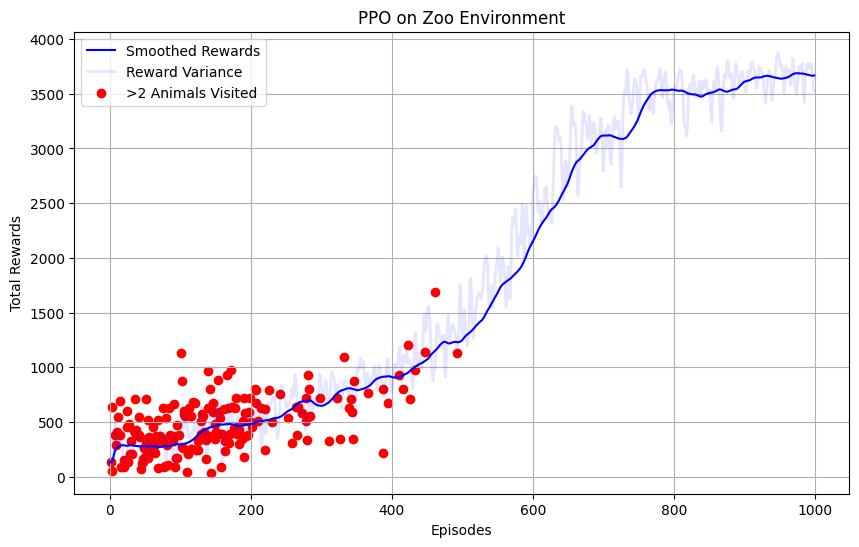

In [ ]:
#training Loop
env = ZooEnv()
state_dim = env._dims[0] * env._dims[1]
action_dim = 4
ppo_agent = PPOAgent(state_dim, action_dim)

num_episodes = 1000
max_timesteps = 100

total_rewards = []
animals_visited_per_episode = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    while not done and steps < max_timesteps:
        action, old_prob = ppo_agent.choose_action(state)
        next_state, reward, done = env.step(action)
        ppo_agent.store_transition((state, action, old_prob, reward, done))
        state = next_state
        total_reward += reward
        steps += 1

    animals_visited = env.get_visited_animals_count()  #number of animals visited in this episode
    animals_visited_per_episode.append(animals_visited)
    total_rewards.append(total_reward)  #total reward for this episode

    if episode % 10 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, Steps: {steps}, Animals Visited: {animals_visited}")

    if len(ppo_agent.memory) >= ppo_agent.update_timestep:
        ppo_agent.update()

#DataFrame for plotting
data = pd.DataFrame({
    'episode': range(len(total_rewards)),
    'reward': total_rewards,
    'animals_visited': animals_visited_per_episode
})


data['reward_smooth'] = data['reward'].rolling(window=50, win_type='triang', min_periods=1).mean()
data['reward_var'] = data['reward'].rolling(window=5, win_type='triang', min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(data['episode'], data['reward_smooth'], color='blue', linewidth=1.5, alpha=1, label='Smoothed Rewards')
plt.plot(data['episode'], data['reward_var'], color='blue', linewidth=2, alpha=0.1, label='Reward Variance')

high_animals_episodes = data[data['animals_visited'] > 2]
plt.scatter(high_animals_episodes['episode'], high_animals_episodes['reward'], color='red', label='>2 Animals Visited')

plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('PPO on Zoo Environment')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

Episode 0/1000, Total Reward: 761, Steps: 79, Animals Visited: 2
Episode 10/1000, Total Reward: 462, Steps: 100, Animals Visited: 2
Episode 20/1000, Total Reward: 331, Steps: 100, Animals Visited: 4
Episode 30/1000, Total Reward: 551, Steps: 100, Animals Visited: 4
Episode 40/1000, Total Reward: 551, Steps: 100, Animals Visited: 3
Episode 50/1000, Total Reward: 89, Steps: 16, Animals Visited: 1
Episode 60/1000, Total Reward: 187, Steps: 25, Animals Visited: 2
Episode 70/1000, Total Reward: 242, Steps: 100, Animals Visited: 3
Episode 80/1000, Total Reward: 551, Steps: 100, Animals Visited: 3
Episode 90/1000, Total Reward: 341, Steps: 100, Animals Visited: 3
Episode 100/1000, Total Reward: 467, Steps: 100, Animals Visited: 4
Episode 110/1000, Total Reward: 388, Steps: 100, Animals Visited: 3
Episode 120/1000, Total Reward: 388, Steps: 100, Animals Visited: 3
Episode 130/1000, Total Reward: 341, Steps: 100, Animals Visited: 1
Episode 140/1000, Total Reward: 568, Steps: 100, Animals Visite

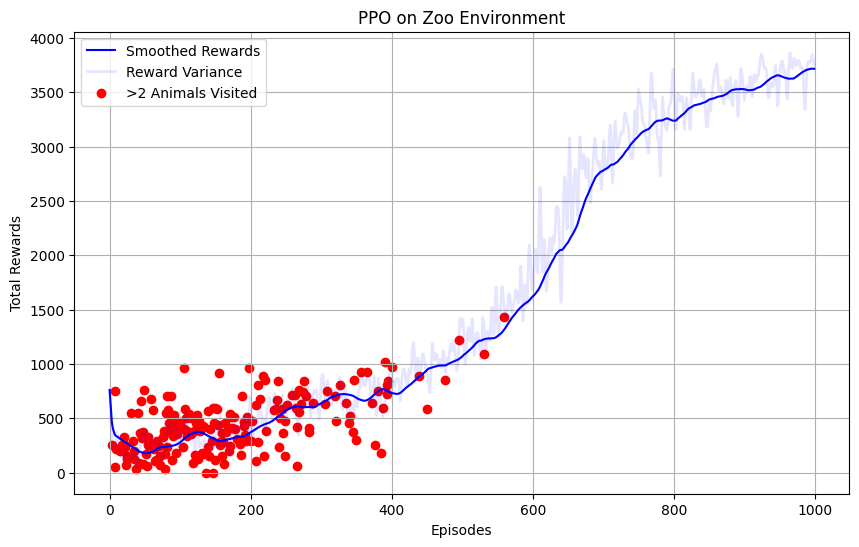

In [ ]:
#Training Loop
env = ZooEnv()
state_dim = env._dims[0] * env._dims[1]
action_dim = 4
ppo_agent = PPOAgent(state_dim, action_dim)

num_episodes = 1000
max_timesteps = 100

total_rewards = []
animals_visited_per_episode = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    steps = 0
    while not done and steps < max_timesteps:
        action, old_prob = ppo_agent.choose_action(state)
        next_state, reward, done = env.step(action)
        ppo_agent.store_transition((state, action, old_prob, reward, done))
        state = next_state
        total_reward += reward
        steps += 1

    animals_visited = env.get_visited_animals_count()  #number of animals visited in this episode
    animals_visited_per_episode.append(animals_visited)
    total_rewards.append(total_reward)  #reward for this episode

    if episode % 10 == 0:
        print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, Steps: {steps}, Animals Visited: {animals_visited}")

    if len(ppo_agent.memory) >= ppo_agent.update_timestep:
        ppo_agent.update()


data = pd.DataFrame({
    'episode': range(len(total_rewards)),
    'reward': total_rewards,
    'animals_visited': animals_visited_per_episode
})


data['reward_smooth'] = data['reward'].rolling(window=50, win_type='triang', min_periods=1).mean()
data['reward_var'] = data['reward'].rolling(window=5, win_type='triang', min_periods=1).mean()


plt.figure(figsize=(10, 6))
plt.plot(data['episode'], data['reward_smooth'], color='blue', linewidth=1.5, alpha=1, label='Smoothed Rewards')
plt.plot(data['episode'], data['reward_var'], color='blue', linewidth=2, alpha=0.1, label='Reward Variance')


high_animals_episodes = data[data['animals_visited'] > 2]
plt.scatter(high_animals_episodes['episode'], high_animals_episodes['reward'], color='red', label='>2 Animals Visited')

plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.title('PPO on Zoo Environment')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()
